### Project 4 - Hackathon! ####
All of the code in this notebook should be considered as joint work that came from the collaboration of the members: Curtis Hope Hill, Mary McAteer, and Kathy Simon.

**Description**

In this project, our group will have four (4) hours to examine and prepare a dataset of movie reviews and build a classification model based on Sentiment Analysis. 

**The sentiment labels are:**
- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [1]:
#imports
import pandas as pd
pd.set_option('display.max_colwidth', 999)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC

np.random.seed(42)

**Importing Data**

In [2]:
#https://stackoverflow.com/questions/9652832/how-to-load-a-tsv-file-into-a-pandas-dataframe
#building training dataframe from .tsv file
df_train = pd.read_csv('./train.tsv', sep='\t')[['SentenceId', 'Phrase', 'Sentiment']]
df_train.head()

,SentenceId,Phrase,Sentiment
0,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,1,A series,2
3,1,A,2
4,1,series,2


In [3]:
#checking out the number of rows:
df_train.shape

(156060, 3)

In [4]:
#checking out nulls and dtypes:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   SentenceId  156060 non-null  int64 
 1   Phrase      156060 non-null  object
 2   Sentiment   156060 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
#looking at all instances where 'SentenceId' = 1
df_train[df_train['SentenceId'] == 1]

,SentenceId,Phrase,Sentiment
0,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,1,A series,2
3,1,A,2
4,1,series,2
...,...,...,...
58,1,much,2
59,1,of a story,2
60,1,a story,2
61,1,story,2


In [6]:
#building testing dataframe from .tsv file
df_test = pd.read_csv('./test.tsv', sep = '\t')[['SentenceId', 'Phrase']]
df_test.head()

,SentenceId,Phrase
0,8545,An intermittently pleasing but mostly routine effort .
1,8545,An intermittently pleasing but mostly routine effort
2,8545,An
3,8545,intermittently pleasing but mostly routine effort
4,8545,intermittently pleasing but mostly routine


In [7]:
#checking out the number of rows:
df_test.shape

(66292, 2)

In [8]:
#checking out nulls and dtypes:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SentenceId  66292 non-null  int64 
 1   Phrase      66292 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SentenceId  66292 non-null  int64 
 1   Phrase      66292 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [10]:
#looking at all instances where 'SentenceId' = 8546
df_test[df_test['SentenceId'] == 8546]

,SentenceId,Phrase
15,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
16,8546,Kidman
17,8546,"is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
18,8546,"is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world"
19,8546,is really
...,...,...
88,8546,post-Full Monty world
89,8546,post-Full
90,8546,Monty world
91,8546,Monty


**Cleaning and EDA**

In [11]:
#dropping the duplicates from the column 'SentenceId'
df_train = df_train.drop_duplicates(subset = 'SentenceId')
df_train.head()

,SentenceId,Phrase,Sentiment
0,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
63,2,"This quiet , introspective and entertaining independent is worth seeking .",4
81,3,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",1
116,4,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .",3
156,5,Aggressive self-glorification and a manipulative whitewash .,1


In [12]:
#repeating the above for the testing data
df_test = df_test.drop_duplicates(subset = 'SentenceId')
df_test.head()

,SentenceId,Phrase
0,8545,An intermittently pleasing but mostly routine effort .
15,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
93,8547,Once you get into its rhythm ... the movie becomes a heady experience .
117,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .
158,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth ."


In [13]:
#baseline model for predictions:
df_train['Sentiment'].value_counts(normalize = True).sort_index()

0    0.125689
1    0.257943
2    0.194044
3    0.272130
4    0.150193
Name: Sentiment, dtype: float64

In [14]:
#CHECK
#CHECK
#CHECK

df_train['Phrase']

0         A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
63                                                                                                                          This quiet , introspective and entertaining independent is worth seeking .
81                                                                                                Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .
116                                           A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .
156                                                                                                                                       Aggressive self-glorification and a manipulative whitewash .
     

- The classes are not equally represented, we'll need to stratify on 'y' when doing train_test_split.

In [15]:
#descriptive stats:
df_train['Sentiment'].describe().drop('count').T

mean    2.063196
std     1.276636
min     0.000000
25%     1.000000
50%     2.000000
75%     3.000000
max     4.000000
Name: Sentiment, dtype: float64

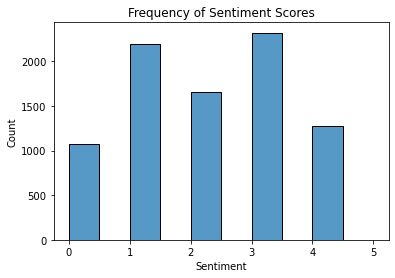

In [16]:
sns.histplot(data = df_train,
             x = 'Sentiment',
             binwidth = .5,
             binrange = (0, 5))
plt.title('Frequency of Sentiment Scores');

**Pre-Processing**

In [17]:
#using bag of words to find and build on additional stop words:
cvec = CountVectorizer(analyzer = 'word',
                       stop_words = 'english',
                       max_features = 25)

# input for CountVectorizer is an array of strings
working_df = df_train['Phrase']

# fit_transform the vectorizer
cvec_stop_words = cvec.fit_transform(working_df)

cvec_stop_words = pd.DataFrame(cvec_stop_words.todense(),
                               columns = cvec.get_feature_names_out())

cvec_stop_words.head()

,bad,best,characters,comedy,director,does,film,funny,good,just,...,make,makes,movie,movies,new,rrb,story,time,way,work
0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
top25words_w_cvec_stopwords = cvec_stop_words.sum().sort_values(ascending = False)[:25]
list(top25words_w_cvec_stopwords.sort_index().keys())

['bad',
 'best',
 'characters',
 'comedy',
 'director',
 'does',
 'film',
 'funny',
 'good',
 'just',
 'life',
 'like',
 'little',
 'love',
 'lrb',
 'make',
 'makes',
 'movie',
 'movies',
 'new',
 'rrb',
 'story',
 'time',
 'way',
 'work']

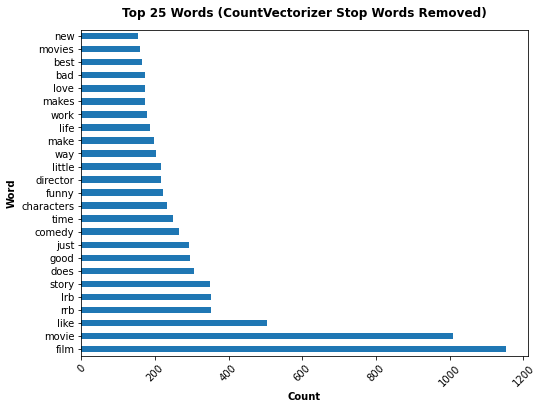

In [19]:
plt.figure(figsize = (8, 6))

plt.title('Top 25 Words (CountVectorizer Stop Words Removed)',
          y = 1.02,
          fontweight = 'bold')

top25words_w_cvec_stopwords.plot(kind = 'barh')

plt.xlabel('Count', 
           fontweight = 'bold')
plt.xticks(rotation = 45)

plt.ylabel('Word',
           fontweight = 'bold');

In [20]:
#forgot stop words import from sklearn at document head:
from sklearn.feature_extraction import text

stop_words = text.ENGLISH_STOP_WORDS

In [21]:
# top 25 words - with stop words (from sklearn)
cvec_sklearn_stop_words = CountVectorizer(stop_words = stop_words,
                                          max_features = 25)

workingdf_sklearn_stop_words = cvec_sklearn_stop_words.fit_transform(working_df)

workingdf_sklearn_stop_words = pd.DataFrame(workingdf_sklearn_stop_words.todense(),
                                            columns = cvec_sklearn_stop_words.get_feature_names_out())

workingdf_sklearn_stop_words.head()

,bad,best,characters,comedy,director,does,film,funny,good,just,...,make,makes,movie,movies,new,rrb,story,time,way,work
0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
top25_words_sklearn_stop = workingdf_sklearn_stop_words.sum().sort_values(ascending = False)[:25]
list(top25_words_sklearn_stop.sort_index().keys())

['bad',
 'best',
 'characters',
 'comedy',
 'director',
 'does',
 'film',
 'funny',
 'good',
 'just',
 'life',
 'like',
 'little',
 'love',
 'lrb',
 'make',
 'makes',
 'movie',
 'movies',
 'new',
 'rrb',
 'story',
 'time',
 'way',
 'work']

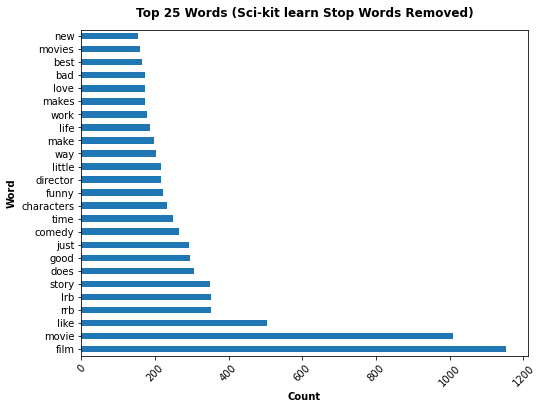

In [23]:
plt.figure(figsize = (8, 6))

#https://datascience.stackexchange.com/questions/91051/how-to-professionally-spell-library-names-such-as-scikit-learn
plt.title('Top 25 Words (Sci-kit learn Stop Words Removed)',
          y = 1.02,
          fontweight = 'bold')

top25_words_sklearn_stop.plot(kind = 'barh')

plt.xlabel('Count', 
           fontweight = 'bold')
plt.xticks(rotation = 45)

plt.ylabel('Word',
           fontweight = 'bold');

- When you exclude Sci-kit learn's stop words and CountVectorizer's stop words, the top 25 words in the corpus are the same. 

In [24]:
#Most common words where 'Sentiment' = 3
#using bag of words to find and build on additional stop words:
cvec = CountVectorizer(analyzer = 'word',
                       stop_words = 'english',
                       max_features = 50) 

df_sentiment3 = df_train[df_train['Sentiment'] == 3]['Phrase']

# fit_transform the vectorizer
sentiment3_words = cvec.fit_transform(df_sentiment3)

# convert output to a Numpy array
sentiment3_words = sentiment3_words.toarray()

In [25]:
#most common words from where 'Sentiment' = 3:
sentiment3_words = cvec.get_feature_names_out()
print(sentiment3_words)

['american' 'best' 'big' 'cast' 'character' 'characters' 'comedy'
 'director' 'does' 'drama' 'end' 'entertaining' 'family' 'film' 'films'
 'fun' 'funny' 'good' 'great' 'heart' 'human' 'just' 'life' 'like'
 'little' 'look' 'love' 'lrb' 'make' 'makes' 'man' 'movie' 'movies' 'new'
 'old' 'people' 'performances' 'real' 'right' 'rrb' 'sense' 'story' 'tale'
 'thriller' 'time' 'way' 'work' 'works' 'world' 'worth']


In [26]:
#setting up customized stop words to use in modeling:
cust_stop_words = stopwords.words('english')

cust_stop_words = cust_stop_words + list(top25_words_sklearn_stop.keys())

In [27]:
cust_stop_words = cust_stop_words + list(stop_words)

**Modeling**

In [28]:
#setting up features and target
X = df_train['Phrase']
y = df_train['Sentiment']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y)

In [29]:
#for ease of reference, baseline accuracy:
y.value_counts(normalize = True).sort_index().round(2)

0    0.13
1    0.26
2    0.19
3    0.27
4    0.15
Name: Sentiment, dtype: float64

## Pipelines

**with CountVectorizer**

In [30]:
# First pipeline:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB()),
])

In [31]:
cross_val_score(pipe, X_train, y_train, cv = 3).mean()

0.3907363056175721

In [32]:
pipe_params = {
    'cvec__stop_words': ['english', cust_stop_words],
    'cvec__max_features': [None, 250, 500], 
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [1.0, .98, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)]
              }

In [33]:
#Instantiating GridSearchCV:
gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv = 5)

In [34]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [1.0, 0.98, 0.95],
                         'cvec__max_features': [None, 250, 500],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                

In [35]:
#function to print results from model:
def gridsearch_outcome(gs_obj):
    preds = gs_obj.predict(X_test)
    res = print(f'Best Score: {gs_obj.best_score_} \n\nBest Params: {gs_obj.best_params_} \n\nClassification Report: \n{classification_report(preds, y_test)}')
    return res

In [36]:
gridsearch_outcome(gs)

Best Score: 0.3691899498351111 

Best Params: {'cvec__max_df': 1.0, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'} 

Classification Report: 
              precision    recall  f1-score   support

           0       0.07      0.42      0.13        38
           1       0.55      0.38      0.45       639
           2       0.12      0.33      0.18       121
           3       0.69      0.39      0.50       815
           4       0.18      0.48      0.26        93

    accuracy                           0.39      1706
   macro avg       0.32      0.40      0.30      1706
weighted avg       0.56      0.39      0.44      1706



In [37]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9677561190092335, 0.3892145369284877)

In [38]:
#generating predictions:
preds = gs.predict(X_test)

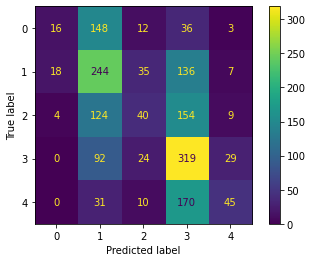

In [39]:
cm = confusion_matrix(y_test,
                      preds,
                      labels= gs.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels= gs.classes_)

disp.plot()
plt.show()

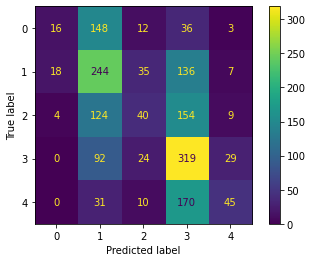

In [40]:
#or like this:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test)

plt.show()

In [41]:
# Second pipeline:
# 1. CountVectorizer (transformer)
# 2. LogReg (estimator)

pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('LogReg', LogisticRegression(max_iter = 10_000)),
                ])

In [63]:
cross_val_score(pipe1, X_train, y_train, cv = 3).mean()

0.36611492875345125

In [42]:
#Instantiating GridSearchCV:
gs1 = GridSearchCV(pipe1,
                   param_grid = pipe_params,
                   cv = 5)

In [43]:
# Fit GridSearch to training data.
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('LogReg',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'cvec__max_df': [1.0, 0.98, 0.95],
                         'cvec__max_features': [None, 250, 500],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                  

In [44]:
gridsearch_outcome(gs1)

Best Score: 0.3703664077857626 

Best Params: {'cvec__max_df': 1.0, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'} 

Classification Report: 
              precision    recall  f1-score   support

           0       0.20      0.42      0.27        99
           1       0.48      0.39      0.43       546
           2       0.27      0.28      0.28       320
           3       0.51      0.41      0.46       574
           4       0.29      0.44      0.35       167

    accuracy                           0.38      1706
   macro avg       0.35      0.39      0.36      1706
weighted avg       0.42      0.38      0.39      1706



In [45]:
gs1.score(X_train, y_train), gs1.score(X_test, y_test)

(0.9928184083247839, 0.38452520515826494)

In [46]:
#generating predictions:
preds1 = gs1.predict(X_test)

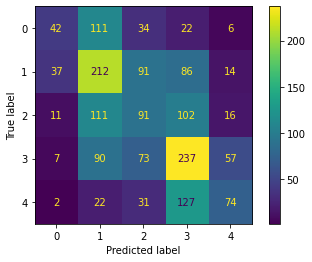

In [47]:
ConfusionMatrixDisplay.from_estimator(gs1, X_test, y_test)

plt.show()

In [48]:
# Third pipeline:
# 1. CountVectorizer (transformer)
# 2. KNN Classifier (estimator)

pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier()),
                ])

In [50]:
knn_pipe_params = {'cvec__stop_words': ['english', cust_stop_words],
                   'cvec__max_features': [None, 250, 500], 
                   'cvec__min_df': [1, 2, 3], 
                   'cvec__max_df': [1.0, .98, .95],
                   'cvec__ngram_range': [(1, 1), (1, 2)],
                   'knn__n_neighbors': [5, 7, 9],
                   'knn__p': [1, 2], 
                  }

In [51]:
#Instantiating GridSearchCV:
gs2 = GridSearchCV(pipe2,
                   param_grid = knn_pipe_params,
                   cv = 5)

In [52]:
# Fit GridSearch to training data.
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [1.0, 0.98, 0.95],
                         'cvec__max_features': [None, 250, 500],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
        

In [53]:
gridsearch_outcome(gs2)

Best Score: 0.27319229157938835 

Best Params: {'cvec__max_df': 1.0, 'cvec__max_features': 250, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'wh

In [54]:
gs2.score(X_train, y_train), gs2.score(X_test, y_test)

(0.40568664810200794, 0.28311840562719814)

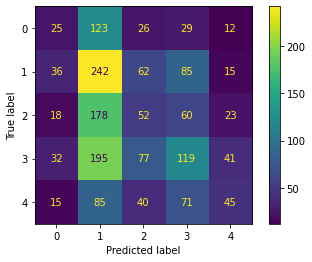

In [55]:
ConfusionMatrixDisplay.from_estimator(gs2, X_test, y_test)

plt.show()

**with TF-IDFVectorizer** 

In [56]:
pipe3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB()),
                ])

In [57]:
tvec_pipe3_params = {'tvec__stop_words': ['english', cust_stop_words],
                     'tvec__max_features': [None, 250, 500], 
                     'tvec__min_df': [1, 2, 3], 
                     'tvec__max_df': [1.0, .98, .95],
                     'tvec__ngram_range': [(1, 1), (1, 2)],
                     }

In [58]:
#Instantiating GridSearchCV:
gs3 = GridSearchCV(pipe3,
                   param_grid = tvec_pipe3_params,
                   cv = 5)

In [59]:
# Fit GridSearch to training data.
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [1.0, 0.98, 0.95],
                         'tvec__max_features': [None, 250, 500],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                

In [60]:
gridsearch_outcome(gs3)

Best Score: 0.3800375968117904 

Best Params: {'tvec__max_df': 1.0, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'} 

Classification Report: 
              precision    recall  f1-score   support

           0       0.03      0.50      0.05        12
           1       0.59      0.38      0.46       684
           2       0.09      0.31      0.14        94
           3       0.73      0.39      0.50       872
           4       0.11      0.61      0.18        44

    accuracy                           0.39      1706
   macro avg       0.31      0.44      0.27      1706
weighted avg       0.62      0.39      0.46      1706



In [61]:
gs3.score(X_train, y_train), gs3.score(X_test, y_test)

(0.6627583174556647, 0.38686987104337633)

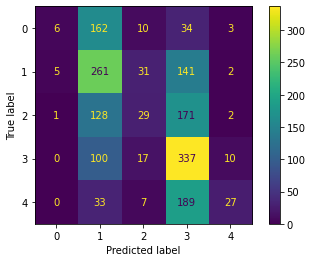

In [62]:
ConfusionMatrixDisplay.from_estimator(gs3, X_test, y_test)

plt.show()

In [67]:
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('LogReg', LogisticRegression(max_iter = 10_000)),
                ])

In [68]:
#Instantiating GridSearchCV:
gs4 = GridSearchCV(pipe4,
                   param_grid = tvec_pipe3_params,
                   cv = 5)

In [69]:
# Fit GridSearch to training data.
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('LogReg',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'tvec__max_df': [1.0, 0.98, 0.95],
                         'tvec__max_features': [None, 250, 500],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                  

In [70]:
gridsearch_outcome(gs4)

Best Score: 0.38047984273790725 

Best Params: {'tvec__max_df': 1.0, 'tvec__max_features': None, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'} 

Classification Report: 
              precision    recall  f1-score   support

           0       0.14      0.44      0.22        71
           1       0.51      0.37      0.42       610
           2       0.20      0.30      0.24       215
           3       0.58      0.40      0.47       676
           4       0.25      0.48      0.33       134

    accuracy                           0.38      1706
   macro avg       0.33      0.40      0.34      1706
weighted avg       0.46      0.38      0.40      1706



In [ ]:
#BREAK BREAK BREAK
#BREAK BREAK BREAK
#BREAK BREAK BREAK
#BREAK BREAK BREAK
#BREAK BREAK BREAK 

In [27]:
#generating predictions:
preds_0 = cvec_logreg_pipe.predict(X_test)

In [28]:
#printing classification report:
print(classification_report(preds_0, y_test))

              precision    recall  f1-score   support

           0       0.19      0.51      0.27       514
           1       0.25      0.50      0.34      2789
           2       0.89      0.64      0.74     22184
           3       0.39      0.52      0.45      4907
           4       0.25      0.56      0.34       818

    accuracy                           0.60     31212
   macro avg       0.39      0.55      0.43     31212
weighted avg       0.73      0.60      0.64     31212



<Figure size 576x576 with 0 Axes>

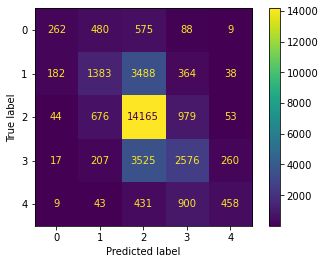

In [29]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));

plot_confusion_matrix(cvec_logreg_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

- Exploring n-grams:

In [53]:
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = None,
                       ngram_range = (2,3))

lr = LogisticRegression(max_iter = 10_000)

In [54]:
#pipeline for cvec with lr, searching bi-grams and tri-grams
cvec_logreg_pipe = Pipeline([('cvec', cvec),
                             ('logreg', lr)])

cvec_logreg_pipe.fit(X_train, y_train)
cvec_logreg_pipe.score(X_train, y_train), cvec_logreg_pipe.score(X_test, y_test)

(0.9827055547413162, 0.28077373974208675)

In [32]:
#generating predictions:
preds_1 = cvec_logreg_pipe.predict(X_test)

In [33]:
#printing classification report:
print(classification_report(preds_1, y_test))

              precision    recall  f1-score   support

           0       0.29      0.52      0.37       791
           1       0.35      0.57      0.43      3392
           2       0.89      0.65      0.75     21806
           3       0.38      0.59      0.46      4241
           4       0.30      0.57      0.39       982

    accuracy                           0.62     31212
   macro avg       0.44      0.58      0.48     31212
weighted avg       0.73      0.62      0.65     31212



<Figure size 576x576 with 0 Axes>

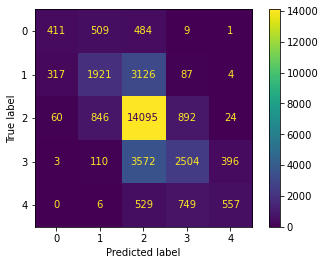

In [34]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(cvec_logreg_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

2. CountVectorizer with MultinomialNB

In [51]:
#re-instatiating cvec, instantiating MultinomialNB
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = 2000)
nb = MultinomialNB()

In [52]:
#pipeline for cvec with nb:
cvec_nb_pipe = Pipeline([('cvec', cvec), 
                        ('nb', nb)])

cvec_nb_pipe.fit(X_train, y_train)
cvec_nb_pipe.score(X_train, y_train), cvec_nb_pipe.score(X_test, y_test)

(0.6265572328887586, 0.365767878077374)

In [37]:
#generating predictions:
preds_2 = cvec_nb_pipe.predict(X_test)

In [38]:
#printing classification report:
print(classification_report(preds_2, y_test))

              precision    recall  f1-score   support

           0       0.15      0.52      0.24       411
           1       0.20      0.51      0.29      2184
           2       0.91      0.61      0.73     23817
           3       0.33      0.52      0.40      4178
           4       0.19      0.56      0.28       622

    accuracy                           0.59     31212
   macro avg       0.36      0.54      0.39     31212
weighted avg       0.76      0.59      0.64     31212



<Figure size 576x576 with 0 Axes>

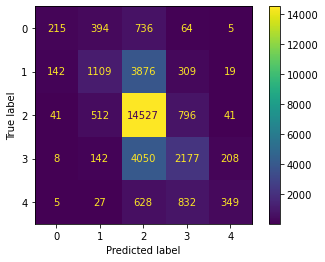

In [39]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(cvec_nb_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

3. CountVectorizer with KNN

In [40]:
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words )
                       
knn = KNeighborsClassifier()

In [41]:
#pipeline for cvec with knn:
pipe_knn_cv = Pipeline([
    ('cvec', cvec),
    ('knn', knn)
])

pipe_knn_cv.fit(X_train, y_train)
pipe_knn_cv.score(X_train, y_train), pipe_knn_cv.score(X_test, y_test)

(0.7223263488401896, 0.6182878380110214)

In [42]:
#generating predictions:
preds_knn = pipe_knn_cv.predict(X_test)

In [43]:
#printing classification report:
print(classification_report(preds_knn, y_test))

              precision    recall  f1-score   support

           0       0.33      0.48      0.39       966
           1       0.39      0.53      0.45      4009
           2       0.87      0.65      0.74     21143
           3       0.38      0.57      0.45      4353
           4       0.24      0.60      0.34       741

    accuracy                           0.62     31212
   macro avg       0.44      0.57      0.48     31212
weighted avg       0.71      0.62      0.65     31212



<Figure size 576x576 with 0 Axes>

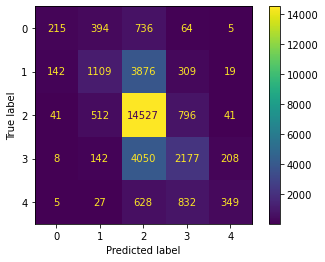

In [44]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(cvec_nb_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

4. TF-IDF with LogReg

In [45]:
#starting modeling with CountVectorizer to vectorizer 'body'
tvec = TfidfVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = 3000)

In [46]:
#pipeline for tvec with lr:
tvec_lr_pipe = Pipeline([
    ('tvec', tvec),
    ('logreg', lr)])

tvec_lr_pipe.fit(X_train, y_train)
tvec_lr_pipe.score(X_train, y_train), tvec_lr_pipe.score(X_test, y_test)

(0.6333701781366141, 0.6099256696142509)

Running the Pipeline with different 'max_features' - Accuracy(train, test):
* none  -   (0.6822696398820967, 0.6323529411764706)
* 500   -   (0.5672097270280662, 0.5618031526336025)
* 1000  -   (0.588876073305139, 0.5803537101114956)
* 2000  -   (0.6186562860438293, 0.5986479559143919)
* 3000  -   (0.6333701781366141, 0.6099256696142509)

In [47]:
#generating predictions:
preds_3 = tvec_lr_pipe.predict(X_test)

In [48]:
#printing classification report:
print(classification_report(preds_3, y_test))

              precision    recall  f1-score   support

           0       0.17      0.56      0.26       432
           1       0.29      0.50      0.37      3112
           2       0.88      0.65      0.75     21574
           3       0.43      0.52      0.47      5408
           4       0.22      0.58      0.31       686

    accuracy                           0.61     31212
   macro avg       0.40      0.56      0.43     31212
weighted avg       0.72      0.61      0.65     31212



<Figure size 576x576 with 0 Axes>

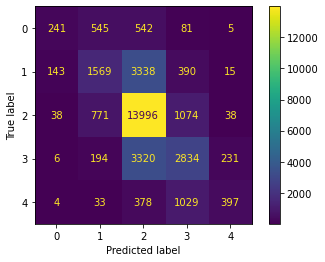

In [49]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(tvec_lr_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

5. TF-IDF with MultinomialNB

In [50]:
#pipeline for tvec with nb:
tvec_nb_pipe = Pipeline([('tvec', cvec), 
                        ('nb', nb)])

tvec_nb_pipe.fit(X_train, y_train)
tvec_nb_pipe.score(X_train, y_train), tvec_nb_pipe.score(X_test, y_test)

(0.6705674099705241, 0.609765474817378)

In [20]:
#generating predictions:
preds_4 = tvec_nb_pipe.predict(X_test)

In [52]:
#printing classification report:
print(classification_report(preds_4, y_test))

              precision    recall  f1-score   support

           0       0.28      0.43      0.34       899
           1       0.41      0.49      0.45      4469
           2       0.79      0.69      0.73     18357
           3       0.50      0.52      0.51      6350
           4       0.30      0.49      0.37      1137

    accuracy                           0.61     31212
   macro avg       0.45      0.52      0.48     31212
weighted avg       0.64      0.61      0.62     31212



<Figure size 576x576 with 0 Axes>

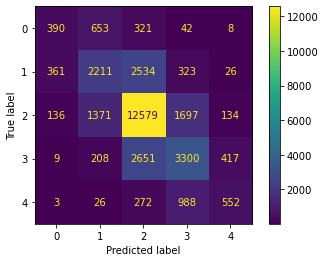

In [53]:
#plotting confusion matrix:
plt.figure(figsize = (8, 8));
plot_confusion_matrix(tvec_nb_pipe, 
                      X_test, y_test, 
                      cmap = 'viridis', 
                      values_format = 'd');

6a. CountVectorizer with Support Vector Machine

In [54]:
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = 2000)                     
svc = SVC(C = 1,
         degree = 2, 
         kernel = 'rbf',
         gamma = 'scale')

In [55]:
#pipe_svc = Pipeline([
#    ('cvec', cvec),
#    ('svc', svc)])

#pipe_svc.fit(X_train, y_train)
#pipe_svc.score(X_train, y_train), pipe_svc.score(X_test, y_test)
#this was run on Curtis Hill's computer, he got the output for the team. 

In [56]:
#output from above cell:
#Train = 0.7176246315519672, Test = 0.6335704216327054

In [ ]:
#preds_5a = pipe_svc.predict(X_test)

In [ ]:
#print(classification_report(preds_5a, y_test))

In [ ]:
#plt.figure(figsize = (8, 8));
#plot_confusion_matrix(pipe_svc, 
#                      X_test, y_test, 
#                      cmap = 'viridis', 
#                      values_format = 'd');

6b. TF-IDF with Support Vector Machine

In [57]:
tfidf = TfidfVectorizer(stop_words= stop_words, 
                             max_features= None,
                            ngram_range= (1,1))

In [58]:
#svc_pipe = Pipeline([
#    ('cvec', cvec),
#    ('svc', svc)])

#svc_pipe.fit(X_train, y_train)
#svc_pipe.score(X_train, y_train), svc_pipe.score(X_test, y_test)
#this was run on Curtis Hill's computer, he got the output for the team. 

In [59]:
#output from above cell:
#Train = 0.7743255799051647, Test = 0.6586569268230168

In [ ]:
#svm_class_report = classification_report(y_test, svm_predict)
#print(svm_class_report)

In [ ]:
#plt.figure(figsize = (8, 8));
#plot_confusion_matrix(svc_pipe, 
#                      X_test, y_test, 
#                      cmap = 'viridis', 
#                      values_format = 'd');

In [84]:
#Again, the SVM was run on Curtis Hill's computer, he got the output for the team. 

- TF-IDF has performed the best on our testing data so far. 

**GridSearching**

In [60]:
pipe_params = {
    'cvec__max_features': [None, 500, 1_000, 1_500, 2_000, 2_500, 3_000], 
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [1.0, .75, .85, .95],
    'cvec__ngram_range': [(1, 1), (1, 2), (1,3), (2,3)]
}

In [61]:
#instantiating GridSearchCV.
gs_cvec = GridSearchCV(cvec_nb_pipe, 
                  param_grid = pipe_params, 
                  cv = 5, 
                  verbose = 1)

In [62]:
#Fiting GridSearch to training data:
#gs_cvec.fit(X_train, y_train)
#gs_cvec.best_params_

#Did not have time to run GridSearch

**Model Evalution**

In [63]:
#re-initializing:
cvec = CountVectorizer(analyzer = 'word',                        
                       stop_words = stop_words, 
                       max_features = 2000)
lr = LogisticRegression(max_iter = 10_000)

In [64]:
#re-initializing:
cvec_logreg_pipe = Pipeline([('cvec', cvec),
               ('logreg', lr),
              ])
cvec_logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=2000,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
            

In [65]:
#generating predictions for testing data from cvec, lr pipeline:
df_test['preds'] = cvec_logreg_pipe.predict(df_test['Phrase'])

In [74]:
#looking at value_counts for testing predictions:
df_test['preds'].value_counts()

2    48575
3     9857
1     5188
4     1646
0     1026
Name: preds, dtype: int64

In [67]:
#Predictions for test data set using the pipeline with Support Vector Machines and Tfidf Vectorizer
#test['predictions'] = pipe_svc_2.predict(test['Phrase'])

#test['predictions'].value_counts()
#From Curtis Hill